In [2]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.1/949.1 kB 18.1 MB/s eta 0:00:00a 0:00:01


In [3]:
import os
import glob
import shutil
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
INPUT_DIR = '/kaggle/input/inme-maske/inmemaske' 
DATASET_DIR = '/kaggle/working/dataset'
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VAL_DIR = os.path.join(DATASET_DIR, 'val')
TEST_DIR = os.path.join(DATASET_DIR, 'test')

os.makedirs(DATASET_DIR, exist_ok=True)
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(DATASET_DIR, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(DATASET_DIR, split, 'labels'), exist_ok=True)


In [8]:
def create_yolo_dataset():
    # Maskeli ve maskesiz görüntülerin yollarını al
    maskeli_iskemik = glob.glob(f'{INPUT_DIR}/maskeli/iskemik/*.png')
    maskeli_kanamali = glob.glob(f'{INPUT_DIR}/maskeli/kanamali/*.png')
    maskesiz_images = glob.glob(f'{INPUT_DIR}/maskesiz/*/*.png')  
    
    # Tüm maskeli görüntüleri birleştir ve eşleştir
    all_maskeli = maskeli_iskemik + maskeli_kanamali
    image_pairs = []
    
    # Görüntüleri eşleştir
    for maskeli_path in all_maskeli:
        base_name = os.path.basename(maskeli_path)
        maskesiz_path = f"{INPUT_DIR}/maskesiz/{'iskemik' if 'iskemik' in maskeli_path else 'kanamali'}/{base_name}"
        if os.path.exists(maskesiz_path):
            image_pairs.append((maskeli_path, maskesiz_path))
    
    # Veriyi karıştır ve böl
    random.shuffle(image_pairs)
    train_size = int(0.7 * len(image_pairs))
    val_size = int(0.15 * len(image_pairs))
    
    train_pairs = image_pairs[:train_size]
    val_pairs = image_pairs[train_size:train_size+val_size]
    test_pairs = image_pairs[train_size+val_size:]
    
    # Bounding box oluşturma fonksiyonu
    def process_pair(pair, split):
        maskeli_path, maskesiz_path = pair
        base_name = os.path.basename(maskeli_path)
        
        # Görüntüleri yükle
        maskeli = cv2.imread(maskeli_path)
        maskesiz = cv2.imread(maskesiz_path)
        
        # Fark maskesi oluştur
        diff = cv2.absdiff(maskeli, maskesiz)
        gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
        
        # Kontur bul
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return
        
        # Bounding box hesapla
        x,y,w,h = cv2.boundingRect(np.vstack(contours))
        x_center = (x + w/2) / 512
        y_center = (y + h/2) / 512
        width = w / 512
        height = h / 512
        
        # Görüntüyü ve etiketi kaydet
        cv2.imwrite(f'{DATASET_DIR}/{split}/images/{base_name}', maskesiz)
        with open(f'{DATASET_DIR}/{split}/labels/{base_name.replace(".png", ".txt")}', 'w') as f:
            f.write(f"0 {x_center} {y_center} {width} {height}")
    
    # Veriyi işle
    for pair in train_pairs: process_pair(pair, 'train')
    for pair in val_pairs: process_pair(pair, 'val')
    for pair in test_pairs: process_pair(pair, 'test')
    
    print(f"Veri dağılımı - Eğitim: {len(train_pairs)}, Doğrulama: {len(val_pairs)}, Test: {len(test_pairs)}")

In [9]:
create_yolo_dataset()

Veri dağılımı - Eğitim: 1556, Doğrulama: 333, Test: 334


In [11]:
yaml_content = f"""
path: {DATASET_DIR}
train: train/images
val: val/images
test: test/images

names:
  0: stroke
"""

with open(f'{DATASET_DIR}/dataset.yaml', 'w') as f:
    f.write(yaml_content)

In [17]:
model = YOLO('yolov8m.pt')  

results = model.train(
    data=f'{DATASET_DIR}/dataset.yaml',
    epochs=50,
    imgsz=512,
    batch=8,                 
    device=0,
    patience=30,             # Uzun iyileşme süresi
    optimizer='SGD',         # SGD + Momentum aktif
    momentum=0.9,            # Momentum değeri
    weight_decay=0.0005,     # L2 regularizasyon
    lr0=0.001,                # Başlangıç learning rate
    lrf=0.01,                 # Final learning rate 
    warmup_epochs=3,         # İlk 3 epoch learning rate artışı
    hsv_h=0.3,               # Renk varyasyonu
    flipud=0.5,              # Dikey çevirme
    mosaic=1.0               # Mozaik artırma
)

Ultralytics 8.3.90 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/dataset/dataset.yaml, epochs=50, time=None, patience=30, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

train: Scanning /kaggle/working/dataset/train/labels.cache... 1556 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1556/1556 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/dataset/val/labels.cache... 333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 333/333 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 4 dataloader workers
Logging results to runs/detect/train6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.29G      2.082      3.738      1.972          5        512: 100%|██████████| 195/195 [00:39<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.63it/s]


                   all        333        333      0.194      0.126     0.0858     0.0412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.29G      1.842      2.628       1.86          8        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.80it/s]

                   all        333        333      0.364      0.207      0.201      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.29G      1.712       2.26       1.77         11        512: 100%|██████████| 195/195 [00:37<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.72it/s]

                   all        333        333       0.53      0.327      0.359      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.29G      1.567      1.914      1.628          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.88it/s]

                   all        333        333      0.519      0.384      0.407      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.29G      1.526       1.75      1.533          7        512: 100%|██████████| 195/195 [00:37<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.74it/s]

                   all        333        333      0.549      0.468      0.494      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.29G      1.433      1.607      1.465          5        512: 100%|██████████| 195/195 [00:37<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.83it/s]

                   all        333        333      0.645      0.495      0.516      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.29G      1.442      1.551      1.461         12        512: 100%|██████████| 195/195 [00:37<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.81it/s]

                   all        333        333      0.607      0.492      0.515      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.29G      1.372      1.453      1.404          3        512: 100%|██████████| 195/195 [00:37<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.64it/s]

                   all        333        333      0.673      0.502      0.581      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.29G      1.387      1.445      1.403          6        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.78it/s]

                   all        333        333      0.635      0.517      0.582      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.29G      1.358      1.413      1.386          8        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.80it/s]

                   all        333        333      0.709      0.508      0.574      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.29G      1.332      1.385       1.35          7        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.80it/s]

                   all        333        333      0.634      0.514      0.579      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.29G      1.321      1.278      1.357          3        512: 100%|██████████| 195/195 [00:37<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.79it/s]

                   all        333        333      0.639      0.568      0.585      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.29G      1.306      1.303      1.344          6        512: 100%|██████████| 195/195 [00:37<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.81it/s]

                   all        333        333      0.769      0.559      0.653       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.29G      1.272       1.24      1.307          3        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.79it/s]

                   all        333        333       0.72      0.529      0.633      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.29G      1.271      1.209      1.305          7        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.79it/s]

                   all        333        333      0.702      0.565      0.645       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.29G      1.311      1.245      1.337          8        512: 100%|██████████| 195/195 [00:37<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.76it/s]

                   all        333        333      0.744       0.55      0.644      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.29G       1.31      1.216      1.336          8        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.83it/s]

                   all        333        333      0.755      0.556      0.653      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.29G      1.275      1.253      1.319          8        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.72it/s]

                   all        333        333      0.756       0.55      0.646      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.29G      1.254      1.186      1.299          6        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.79it/s]

                   all        333        333      0.811      0.565      0.673      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.29G       1.26      1.212      1.303          9        512: 100%|██████████| 195/195 [00:37<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.78it/s]

                   all        333        333      0.767      0.556      0.655      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.29G      1.215      1.106      1.274          9        512: 100%|██████████| 195/195 [00:37<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.67it/s]

                   all        333        333      0.804       0.59      0.692       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.29G      1.248      1.148      1.286          7        512: 100%|██████████| 195/195 [00:37<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.83it/s]

                   all        333        333      0.752      0.601      0.669      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.29G      1.224      1.135      1.278          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.82it/s]

                   all        333        333       0.75      0.592      0.688      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.29G      1.248      1.169      1.274          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.85it/s]

                   all        333        333      0.834      0.542      0.661      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.29G      1.182      1.084      1.249          6        512: 100%|██████████| 195/195 [00:37<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.82it/s]

                   all        333        333      0.805      0.562      0.667      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.29G      1.205      1.099      1.263          6        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.78it/s]

                   all        333        333      0.728      0.628      0.678      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.29G      1.209      1.063      1.254          7        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.82it/s]

                   all        333        333      0.717      0.638        0.7      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.29G      1.191      1.066      1.267          6        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.78it/s]

                   all        333        333      0.728      0.579      0.665      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.29G      1.196      1.076       1.25          6        512: 100%|██████████| 195/195 [00:37<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.81it/s]

                   all        333        333      0.728      0.634      0.689      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.29G      1.224      1.066      1.262          9        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.83it/s]

                   all        333        333      0.697      0.658      0.699      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.29G      1.192      1.049      1.238         12        512: 100%|██████████| 195/195 [00:37<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.76it/s]

                   all        333        333      0.712      0.623      0.675      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.29G      1.184      1.038      1.234          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.87it/s]

                   all        333        333      0.731      0.619      0.689      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.29G      1.179      1.019      1.235          8        512: 100%|██████████| 195/195 [00:37<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.81it/s]

                   all        333        333      0.769      0.574      0.693      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.29G      1.155       1.01      1.227          8        512: 100%|██████████| 195/195 [00:37<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.77it/s]

                   all        333        333      0.831      0.559      0.697      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.29G      1.143     0.9889      1.217          6        512: 100%|██████████| 195/195 [00:37<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.84it/s]

                   all        333        333      0.776       0.64      0.725      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.29G      1.179       1.01      1.241          9        512: 100%|██████████| 195/195 [00:37<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.89it/s]

                   all        333        333      0.765      0.636      0.719      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.29G      1.155     0.9965      1.227          9        512: 100%|██████████| 195/195 [00:37<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.87it/s]

                   all        333        333      0.787      0.622      0.706      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.29G      1.148     0.9728      1.212          6        512: 100%|██████████| 195/195 [00:37<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.83it/s]

                   all        333        333      0.779      0.649      0.717      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.29G      1.161     0.9561      1.228          8        512: 100%|██████████| 195/195 [00:37<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.85it/s]

                   all        333        333      0.816      0.625      0.721       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.29G       1.16     0.9691      1.219          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.83it/s]

                   all        333        333       0.87      0.574      0.718      0.463


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.29G      1.109     0.8693      1.196          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.78it/s]

                   all        333        333      0.857      0.583      0.715      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.29G      1.076     0.8286      1.176          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.78it/s]

                   all        333        333      0.758      0.668      0.731      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.29G      1.063      0.799      1.174          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.82it/s]

                   all        333        333      0.773      0.667      0.739      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.29G      1.055     0.8022      1.172          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.77it/s]

                   all        333        333      0.725      0.706      0.745      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.29G      1.063     0.7985      1.171          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.86it/s]

                   all        333        333      0.834      0.631      0.741      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.29G      1.053     0.7831      1.176          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.86it/s]

                   all        333        333      0.763      0.685       0.74      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.29G      1.043     0.7577      1.161          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.78it/s]

                   all        333        333      0.856      0.616      0.736      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.29G      1.044     0.7834      1.169          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.84it/s]

                   all        333        333      0.774      0.658      0.733      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.29G      1.049      0.747      1.169          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.80it/s]

                   all        333        333      0.787      0.665      0.742      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.29G      1.042     0.7542       1.16          4        512: 100%|██████████| 195/195 [00:37<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.83it/s]

                   all        333        333      0.754        0.7      0.746      0.479



50 epochs completed in 0.579 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 52.0MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.90 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  5.20it/s]


                   all        333        333      0.786      0.661      0.742      0.479


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 7.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train6


In [18]:
metrics = model.val()
print(f"Model performansı: mAP50-95: {metrics.box.map}")


Ultralytics 8.3.90 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /kaggle/working/dataset/val/labels.cache... 333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 333/333 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:07<00:00,  5.80it/s]


                   all        333        333      0.787      0.664      0.743      0.479


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 17.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train62
Model performansı: mAP50-95: 0.47944479728075934



image 1/1 /kaggle/working/dataset/test/images/15626.png: 512x512 1 stroke, 25.3ms
Speed: 1.1ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)


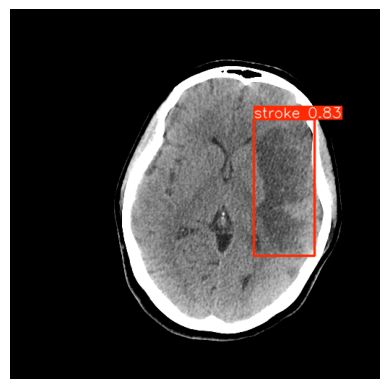


image 1/1 /kaggle/working/dataset/test/images/11535.png: 512x512 (no detections), 25.3ms
Speed: 0.9ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)


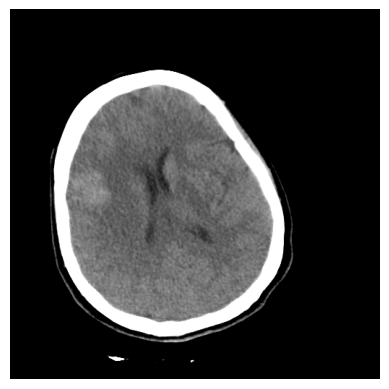


image 1/1 /kaggle/working/dataset/test/images/11896.png: 512x512 1 stroke, 25.4ms
Speed: 1.0ms preprocess, 25.4ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)


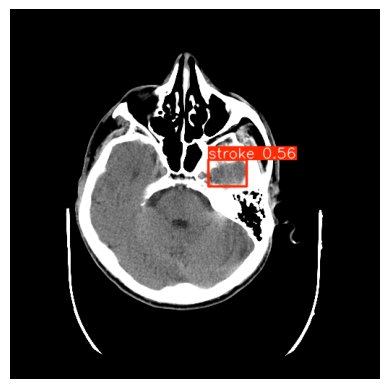

In [19]:
test_images = glob.glob(f'{DATASET_DIR}/test/images/*.png')[:3]

for img_path in test_images:
    results = model.predict(img_path, conf=0.5)
    plotted = results[0].plot()
    plt.imshow(plotted)
    plt.axis('off')
    plt.show()